In [1]:
import isaacgym
from motion_lib import MotionLib

2024-09-03 23:50:36,884 - INFO - logger - logger initialized


Importing module 'gym_38' (/home/mankaran/Desktop/rl/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/mankaran/Desktop/rl/IsaacGym_Preview_4_Package/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json
Error: FBX library failed to load - importing FBX data will not succeed. Message: /home/mankaran/.local/lib/python3.8/site-packages/fbx.cpython-38-x86_64-linux-gnu.so: undefined symbol: xmlFree
FBX tools must be installed from https://help.autodesk.com/view/FBX/2020/ENU/?guid=FBX_Developer_Help_scripting_with_python_fbx_installing_python_fbx_html


In [2]:
import os
import numpy as np 
import matplotlib.pyplot as plt

motion_files_path = "/home/mankaran/Desktop/rl/IsaacGym_Preview_4_Package/isaacgym/IsaacGymEnvs/assets/amp/motions"
motion_files = os.listdir(motion_files_path)
motion_files

['amp_humanoid_run.npy',
 'amp_humanoid_walk.npy',
 'amp_humanoid_cartwheel.npy',
 'amp_humanoid_hop.npy',
 'amp_humanoid_backflip.npy',
 'amp_humanoid_dance.npy']

In [3]:
motion_file = os.path.join(motion_files_path, motion_files[3])

In [4]:
num_dof = 28
key_body_ids = np.array([5,  8, 11, 14])
KEY_BODY_NAMES = ["right_hand", "left_hand", "right_foot", "left_foot"]

motion_lib = MotionLib(motion_file=motion_file, 
                        num_dofs=num_dof,
                        key_body_ids=key_body_ids, 
                        device="cpu")

Loading 1/1 motion files: /home/mankaran/Desktop/rl/IsaacGym_Preview_4_Package/isaacgym/IsaacGymEnvs/assets/amp/motions/amp_humanoid_hop.npy
Loaded 1 motions with a total length of 4.933s.


In [5]:
root_pos, root_rot, dof_pos, root_vel, root_ang_vel, dof_vel, key_pos = motion_lib.get_motion_state(np.array([0, 0]), np.array([0, 1]))
motion = motion_lib.get_motion(0)

(2, 3) (2, 4) (2, 15, 4) (2, 3) (2, 3) (2, 4, 3) (2, 28)


In [6]:
dof_pos.shape

torch.Size([2, 28])

In [ ]:
from isaacgymenvs.utils.torch_jit_utils import to_torch, slerp, quat_to_exp_map, quat_to_angle_axis, normalize_angle
import torch

DOF_BODY_IDS = [1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14]
DOF_OFFSETS = [0, 3, 6, 9, 10, 13, 14, 17, 18, 21, 24, 25, 28]

def local_rotation_to_dof(local_rot):
        body_ids = DOF_BODY_IDS
        dof_offsets = DOF_OFFSETS

        n = local_rot.shape[0]
        dof_pos = torch.zeros((n, num_dof), dtype=torch.float, device='cpu')

        for j in range(len(body_ids)):
            body_id = body_ids[j]
            joint_offset = dof_offsets[j]
            joint_size = dof_offsets[j + 1] - joint_offset

            if (joint_size == 3):
                joint_q = local_rot[:, body_id]
                joint_exp_map = quat_to_exp_map(joint_q)
                dof_pos[:, joint_offset:(joint_offset + joint_size)] = joint_exp_map
            elif (joint_size == 1):
                joint_q = local_rot[:, body_id]
                joint_theta, joint_axis = quat_to_angle_axis(joint_q)
                joint_theta = joint_theta * joint_axis[..., 1] # assume joint is always along y axis

                joint_theta = normalize_angle(joint_theta)
                dof_pos[:, joint_offset] = joint_theta

            else:
                print("Unsupported joint type")
                assert(False)

        return dof_pos

In [7]:
dof_pos = local_rotation_to_dof(motion.local_rotation)

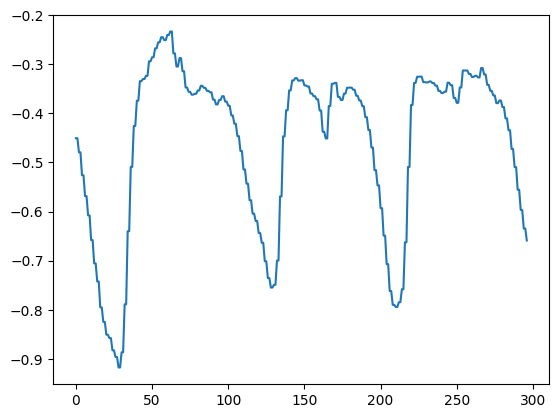

In [8]:
plt.plot(dof_pos[:, 4])

In [9]:
motion.skeleton_tree.node_names

['pelvis',
 'torso',
 'head',
 'right_upper_arm',
 'right_lower_arm',
 'right_hand',
 'left_upper_arm',
 'left_lower_arm',
 'left_hand',
 'right_thigh',
 'right_shin',
 'right_foot',
 'left_thigh',
 'left_shin',
 'left_foot']

In [10]:
motion.skeleton_tree

SkeletonTree(
    node_names=['pelvis', 'torso', 'head', 'right_upper_arm', 'right_lower_arm', 'right_hand', 'left_upper_arm', 'left_lower_arm', 'left_hand', 'right_thigh', 'right_shin', 'right_foot', 'left_thigh', 'left_shin', 'left_foot'],
    parent_indices=tensor([-1,  0,  1,  1,  3,  4,  1,  6,  7,  0,  9, 10,  0, 12, 13]),
    local_translation=tensor([[ 0.0000,  0.0000,  1.0000],
            [ 0.0000,  0.0000,  0.2362],
            [ 0.0000,  0.0000,  0.2239],
            [-0.0240, -0.1831,  0.2435],
            [ 0.0000,  0.0000, -0.2748],
            [ 0.0000,  0.0000, -0.2589],
            [-0.0240,  0.1831,  0.2435],
            [ 0.0000,  0.0000, -0.2748],
            [ 0.0000,  0.0000, -0.2589],
            [ 0.0000, -0.0849,  0.0000],
            [ 0.0000,  0.0000, -0.4215],
            [ 0.0000,  0.0000, -0.4099],
            [ 0.0000,  0.0849,  0.0000],
            [ 0.0000,  0.0000, -0.4215],
            [ 0.0000,  0.0000, -0.4099]])
)

In [7]:
a = np.load(motion_file, allow_pickle=True)

In [10]:
DOF_BODY_IDS = [1, 2, 3, 4, 6, 7, 9, 10, 11, 12, 13, 14]
DOF_OFFSETS = [0, 3, 6, 9, 10, 13, 14, 17, 18, 21, 24, 25, 28]

BODY_NAMES_ISAAC_GYM = ['pelvis', 'torso', 'head', 'right_upper_arm', 'right_lower_arm', 'right_hand', 'left_upper_arm', 'left_lower_arm', 'left_hand', 
                        'right_thigh', 'right_shin', 'right_foot', 'left_thigh', 'left_shin', 'left_foot']

BODY_NAMES = ['pelvis', 'torso', 'right_thigh', 'left_thigh', 'head', 'left_upper_arm', 'right_upper_arm', 'right_shin', 'left_shin',
               'left_lower_arm', 'right_lower_arm', 'right_foot', 'left_foot', 'left_hand', 'right_hand']

KEY_BODY_NAMES = ["right_hand", "left_hand", "right_foot", "left_foot"]

In [12]:
def get_dofs_offsets(body_names, body_ids, body_offsets):
    offsets = {}
    for i, body in enumerate(body_ids):
        offsets[body_names[body]] = [body_offsets[i], body_offsets[i+1]]
    return offsets

In [ ]:
get_dofs_offsets(BODY_NAMES, )

In [11]:
offsets = {}
new_ids = []

for i, body_gym in enumerate(DOF_BODY_IDS):
    print(BODY_NAMES_ISAAC_GYM[body_gym], [DOF_OFFSETS[i], DOF_OFFSETS[i+1]])
    offsets[BODY_NAMES_ISAAC_GYM[body_gym]] = [DOF_OFFSETS[i], DOF_OFFSETS[i+1]]
    new_ids.append(BODY_NAMES.index(BODY_NAMES_ISAAC_GYM[body_gym]))
    
offsets, new_ids

torso [0, 3]
head [3, 6]
right_upper_arm [6, 9]
right_lower_arm [9, 12]
right_hand [12, 15]
left_upper_arm [15, 18]
left_lower_arm [18, 19]
left_hand [19, 20]
right_thigh [20, 21]
right_shin [21, 22]
right_foot [22, 25]
left_thigh [25, 28]


({'torso': [0, 3],
  'head': [3, 6],
  'right_upper_arm': [6, 9],
  'right_lower_arm': [9, 12],
  'right_hand': [12, 15],
  'left_upper_arm': [15, 18],
  'left_lower_arm': [18, 19],
  'left_hand': [19, 20],
  'right_thigh': [20, 21],
  'right_shin': [21, 22],
  'right_foot': [22, 25],
  'left_thigh': [25, 28]},
 [1, 4, 6, 10, 14, 5, 9, 13, 2, 7, 11, 3])

In [26]:
arr = list(range(28))
shuffle = [0]*28

In [27]:
i = 0
for body_name in BODY_NAMES:
    offset = offsets.get(body_name, None)
    if offset is None:
        continue
    offset_range = offset[1] - offset[0]
    shuffle[i:i+offset_range] = arr[offset[0]:offset[1]] 
    i += offset_range
shuffle


[0,
 1,
 2,
 14,
 15,
 16,
 21,
 22,
 23,
 3,
 4,
 5,
 10,
 11,
 12,
 6,
 7,
 8,
 17,
 24,
 13,
 9,
 18,
 19,
 20,
 25,
 26,
 27]